## Problem Definition

This is a dataset about users who hit one shopping website. My goal is to identify the conversion rate of a website, i.e. to predict how likely that the site tends to turn lookers into buyers. Meanwhile, I will offer some recommendations for the team to improve conversion rate. The dataset is quite straight-forward and consists of whether they converted or not as well as some of users charasteristics such as their country, the marketing channel, their age, whether they are new or old users and the number of pages visited during that session. 

## Roadmap

I am exploring this problem mainly by following steps:
1. Load and clean the data
2. Discover and visualize the data to gain insights
3. Prepare the data for Machine Learning algorithms
4. Establish a baseline model that I aim to exceed
4. Select Random Forest model and train it
5. Fine-tune the model and determine performance metrics
6. Feature importance
6. Conclusion and offer recommendation

 


In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import missingno as msno
from sklearn.utils import resample
# Import train_test_split function
from sklearn.model_selection import train_test_split
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve,roc_auc_score, auc
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from collections import OrderedDict

## Load and Clean Data

In [2]:
df = pd.read_csv('conversion_data.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


#### 1. Missing values

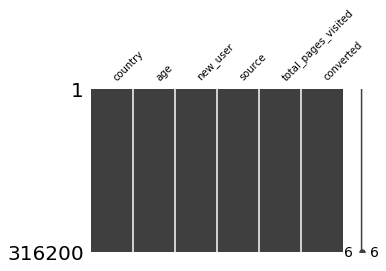

In [3]:
#missingno package is used to visualize the missing data in this dataset.
msno.matrix(df,figsize=(5,3),width_ratios=(15, 1),fontsize=10);

It is clear that there is no missing value in this dataset. Next step is to check outliers.

#### 2. Outliers

In [4]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [5]:
df[df['age']>100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


We could see that for age variable, maximum with 123 is a little abnormal and it might be a mistake. Since there is only two records over 100yrs, to avoid impacting our final result and analysis, I will directly remove these two outliers.

In [6]:
df = df[df['age']<100]

## Discover and visualize the data to gain insights



In [7]:
print('Variable', '   ', 'count of unique value','  ', 'content')
for column in df.columns:
    uniques = sorted(df[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])
    

Variable     count of unique value    content
country                  4	 ['China', 'Germany', 'UK', 'US']
age                     58	 [17, 18, 19, 20, 21]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5]
converted                2	 [0, 1]


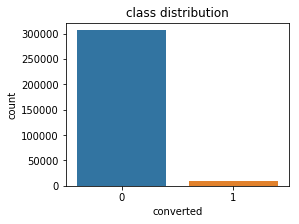

In [8]:
# class converted visualization
plt.subplots(1,1,figsize=(4,3))
sns.countplot(df['converted']);
plt.title('class distribution');

In [9]:
convert_0 = len(df[df['converted']==0]['converted'])
convert_1 = len(df[df['converted']==1]['converted'])
no_conversion = convert_0/(convert_0+convert_1)*100
print('Number of lookers who buy something:',convert_1)
print('Number of lookers who buy nothing:',convert_0)
print('In this dataset,',no_conversion,'%','visitors do not convert.')

Number of lookers who buy something: 10198
Number of lookers who buy nothing: 306000
In this dataset, 96.77480565974484 % visitors do not convert.


Obviously, this is an unbalanced dataset. If I just directly make my model classify all instances as the majority class, then accuracy is already high. It is clear that in this case accuracy is not an appropriate metric any more to evaluate model performance.

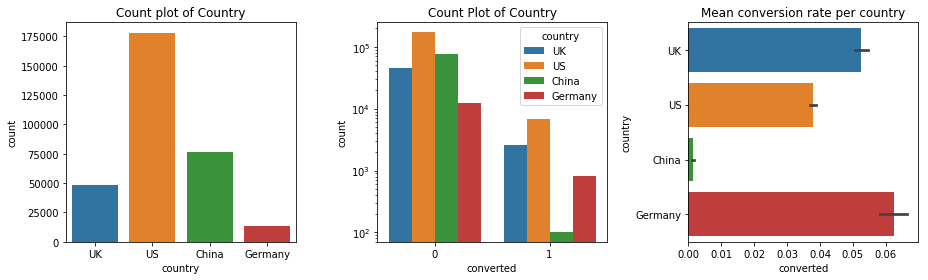

In [10]:
# Country variable visualization
fig, ax = plt.subplots(1,3,figsize=(13,4))
sns.countplot(df['country'],ax=ax[0]);
ax[0].set_title('Count plot of Country',fontsize=12);
sns.countplot(df['converted'],hue=df['country'],ax=ax[1]);
ax[1].set_yscale('log')
ax[1].set_title('Count Plot of Country',fontsize=12)
sns.barplot(df['converted'],df['country'],ax=ax[2]);
ax[2].set_title('Mean conversion rate per country',fontsize=12);

plt.tight_layout()
plt.show()

These three figures generally show that:
1. Users mainly originate from United States but their conversion rate is not number one.
2. There are many users in China, but mean conversion rate is extremely low.
3. Website in Germany has the fewest users but the highest conversion rate.

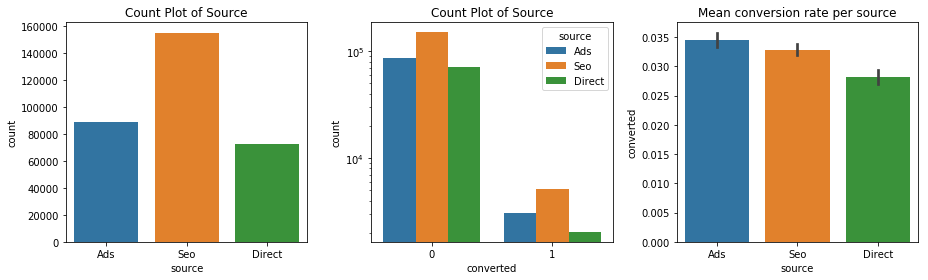

In [11]:
# Source variable visualization
sour = df[['source','converted']].groupby('source').mean().reset_index()
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(13,4))
sns.countplot(df['source'],ax=ax[0]);
ax[0].set_title('Count Plot of Source')
sns.countplot(df['converted'], hue=df['source'],data=df,ax=ax[1]);
ax[1].set_yscale('log')
ax[1].set_title('Count Plot of Source',fontsize=12);
sns.barplot(x='source',y='converted',data=df,ax=ax[2]);
ax[2].set_title('Mean conversion rate per source',fontsize=12);
plt.tight_layout()
plt.show()

The mainly information I get from above plot is:
1. Clicking on search results(Seo) is the most common way for users to came to the site and it does own the most converted people, but its mean conversion rate does not rank first.
2. Users who are attracted by advertisement(Ads) have the highest mean conversion rate.
3. Few users who came to the site by directly typing the URL(Diret) are with least converted people and lowest mean conversion rate. 

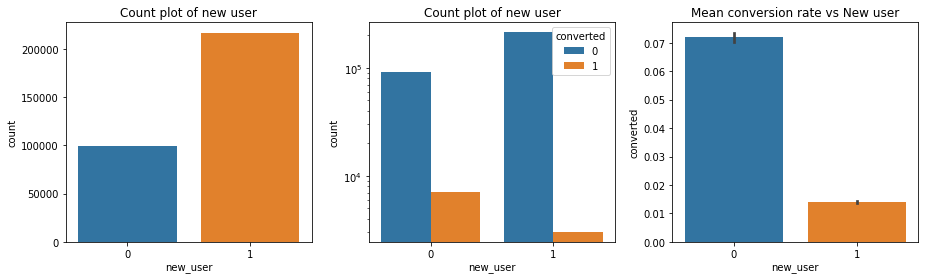

In [12]:
# New user variable visualization
fig, ax = plt.subplots(1,3,figsize=(13,4))
sns.countplot(df['new_user'],ax=ax[0])
ax[0].set_title('Count plot of new user')
sns.countplot(df['new_user'],hue=df['converted'],ax=ax[1])
ax[1].set_yscale('log')
ax[1].set_title('Count plot of new user')
sns.barplot(x='new_user',y='converted',data=df,ax=ax[2])
ax[2].set_title('Mean conversion rate vs New user')
plt.tight_layout()
plt.show()

What I get from the data is:
1. Two thirds of lookers are new users and the rest are repeat users.
2. Probability of conversion of old users is over that of new users.

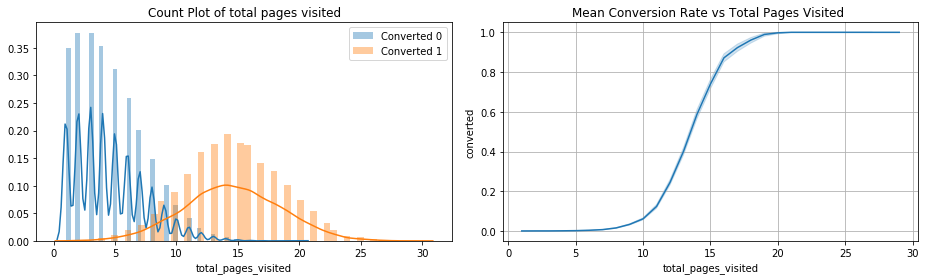

In [13]:
# Total pages visited variable visualization
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(13,4))
con_0 = df[df['converted']==0]['total_pages_visited']
con_1 = df[df['converted']==1]['total_pages_visited']
sns.distplot(con_0,label='Converted 0', ax=ax[0])
sns.distplot(con_1,label='Converted 1', ax=ax[0])
ax[0].legend()
ax[0].set_title('Count Plot of total pages visited',fontsize=12);
sns.lineplot(x='total_pages_visited',y='converted',data=df,ax=ax[1], markers=True, dashes=False);
ax[1].set_title('Mean Conversion Rate vs Total Pages Visited ',fontsize=12);
ax[1].grid(True)
plt.tight_layout()
plt.show()

For total pages visited variable:
1. Users who buy something obviously visit more pages than that who buy nothing.
2. Most of converted users browse 10 to 20 pages.
3. Nonconverted users often visit pages less than 15.

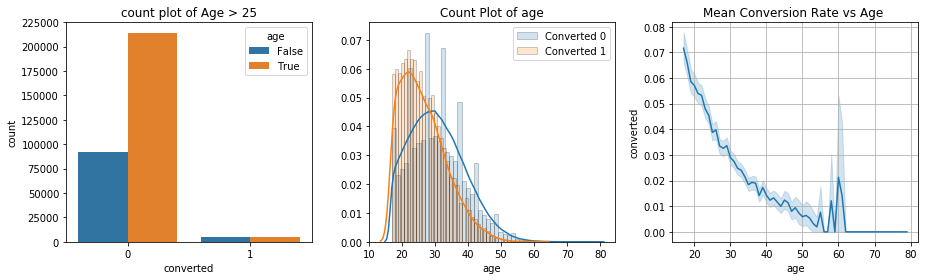

In [14]:
# Age variable visualization
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(13,4))
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
sns.countplot(df['converted'],hue=df['age']>25,ax=ax[0])
ax[0].set_title('count plot of Age > 25')
con_0 = df[df['converted']==0]['age']
con_1 = df[df['converted']==1]['age']
sns.distplot(con_0,label='Converted 0', ax=ax[1],hist_kws=hist_kws)
sns.distplot(con_1,label='Converted 1', ax=ax[1],hist_kws=hist_kws)
ax[1].legend()
ax[1].set_title('Count Plot of age',fontsize=12);
sns.lineplot(x='age',y='converted',data=df,ax=ax[2]);
ax[2].set_title('Mean Conversion Rate vs Age ',fontsize=12);
ax[2].grid(True)
plt.tight_layout()
plt.show()

Age variable tells me:
1. For converted users, 50% users are older than 25yrs. However, for non-converted ones, over 70% users are older than 25yrs.
1. The average age of converted people is less than that of non-converted people.
2. For users under 55, the older the age, the lower the mean conversion rate.

## Prepare the data for Machine Learning algorithms

One-hot encoding categorical features into numerical value 

In [15]:
dataset= df.copy()
dataset=pd.get_dummies(dataset, columns=['country','source'], prefix=['country','source'])
dataset = dataset.reset_index()

X_new = dataset[['age', 'new_user', 'total_pages_visited', 'country_China',
       'country_Germany', 'country_UK', 'country_US', 'source_Ads',
       'source_Direct', 'source_Seo']]
y_new = dataset['converted']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, test_size=0.3) # 70% training and 30% test


I am picking random forests model to predict conversion rate, and the main reasons are:
1. It is more robust than a single decision tree, and less likely to overfit on the training data.
2. It offers a really good idea of which features are more important to help me analyze and give recommendations. 
3. I can tune parameter 'class_weight' in random forests to handle with imbalanced classes.
4. OOB error can be viewd as a valid estimate of the test error which is convenient when performing cross-validation on large data set would be computationally cubersome.



## Establish a baseline model that I aim to exceed

In [16]:
# The baseline model will classifiy all the observations to majority classes
baseline_preds = 0 # majority class not converted
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - y_test)
print('Average baseline prediction accuracy: ', (1-round(np.mean(baseline_errors), 4))*100,'%')


Average baseline prediction accuracy:  96.81 %


Actually, for imbalanced dataset, using accuracy as metric is not a smart way, but it still give us a sense for measuring model performance. I am going to utilize ROC curve and PR curve to evaluate the model.

## Select Random Forest model and train it

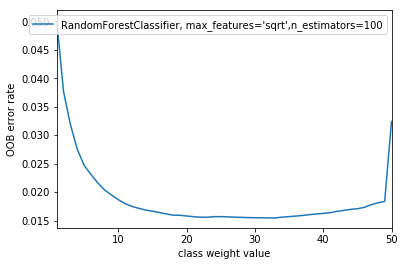

In [17]:
# use OOB error to tune parameter 'class weight'
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt',n_estimators=100",
        RandomForestClassifier(n_estimators=100,
                               class_weight='balanced', oob_score=True,
                               max_features="sqrt",
                               random_state=123))
]
# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of class weight values to explore. [0:(0.02~1),1:(0.98~0)]
min_value = 1
max_value = 50

for label, clf in ensemble_clfs:
    for i in range(min_value, max_value + 1):
        clf.set_params(class_weight={0:i*0.02,1:(1-i*0.02)})
        clf.fit(X_train, y_train)

        # Record the OOB error for each value=i setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "class weight" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_value, max_value)
plt.xlabel("class weight value")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [18]:
#Create a Random Forest Classifier using parameters we just get
clf=RandomForestClassifier(n_estimators=100,oob_score=True,class_weight={0:0.48,1:0.51},max_features="sqrt",
                               random_state=123,max_depth=9)
#Train the model using the training sets
clf.fit(X_train,y_train)

#OOB score
clf.oob_score_ 

0.9859626453659109

## Determine Performance Metrics

In [19]:
# Use the forest's predict method on the train data
y_train_pred = clf.predict_proba(X_train)

# compute tpr, fpr to plot ROC curve for training set
fpr_train, tpr_train, thresholds = roc_curve(y_train, y_train_pred[:,1])
roc_auc = auc(fpr_train, tpr_train)

# Use the forest's predict method on the test data
y_pred = clf.predict_proba(X_test)

# compute tpr, fpr to plot ROC curve for test set
fpr_test, tpr_test, thresholds = roc_curve(y_test, y_pred[:,1])
roc_auc_test = auc(fpr_test, tpr_test)

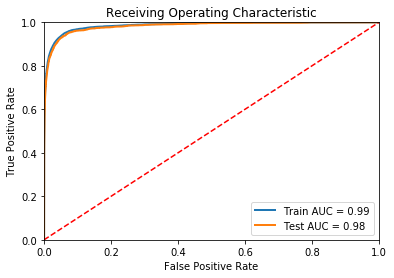

In [20]:
# Plot ROC curve and compare them
plt.plot(fpr_train, tpr_train,  linewidth=2, label='Train AUC = %0.2f'% roc_auc);
plt.plot(fpr_test, tpr_test, linewidth=2, label='Test AUC = %0.2f'% roc_auc_test)
plt.title("Receiving Operating Characteristic")
plt.legend(loc="lower right")
plt.plot([0, 1], [0, 1], 'r--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Here looking at the ROC curve (and the ROC AUC score), no matter on training set or test set, the classifier both perform well. The TPR here is the ratio of (postive)converted users that are correctly classified as converted group, which is large in this case. The FPR is the ratio of (negative) nonconverted users that are incorrectly classfied as (positive)converted, which is small here. However, due to the imbalancity of this data set, i.e. there are few converted users(positive) compared to the nonconverted ones(negative). Consequently, it makes sense that TPR will be large. Thus, I will look at another tool Precision-Recall curve to help me measure my model.

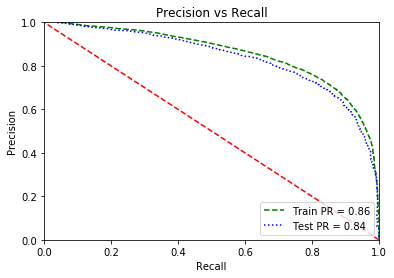

In [21]:
# Plot PR curve and compare results
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_pred[:,1] )
precisions_test, recalls_test, thresholds = precision_recall_curve(y_test, y_pred[:,1])
PR_train = auc(recalls,precisions)
PR_test = auc(recalls_test,precisions_test)
plt.plot(precisions,recalls,'g--',label='Train PR = %0.2f'% PR_train)
plt.plot(precisions_test,recalls_test,'b:',label='Test PR = %0.2f'% PR_test)
plt.legend(loc="lower right")
plt.plot([1, 0], [0, 1], 'r--')
plt.axis([0, 1, 0, 1])
plt.title('Precision vs Recall')
plt.ylabel('Precision')
plt.xlabel('Recall');

In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-right corner). 

In [22]:
Y = []
for i in range(y_pred.shape[0]):
    if y_pred[i][0] > y_pred[i][1]:
        Y.append(0)
    else:
        Y.append(1)
print(classification_report(y_true=y_test, y_pred=Y))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99     91834
          1       0.85      0.69      0.76      3026

avg / total       0.99      0.99      0.99     94860



It shows that for class converted, if we use the default cutoff 0.5, we can have a high precision (0.85), but a relative low recall 0.69, which means we classify 30% converted user as non-converted. In practice, we can choose a specific value for recall or precision by adjusting threshold according to our business goal. For example, if sales team and maketing team think that improving retention is our goal in this stage, then correctly identified converted users is more important, i.e. recall should be increased. On the other hand, if we tend to increase conversion rate of new users, then precision should be fully considered. In a nutshell, there has a trade-off between precision and recall.

In [23]:
print('Train set prediction accuracy is:',clf.score(X_train,y_train))
print('Test set prediction accuracy is:',clf.score(X_test,y_test))

Train set prediction accuracy is: 0.9867307014611137
Test set prediction accuracy is: 0.9861374657389838


The accuracy of baseline model is 96.76%, obviously, random forests method outperforms it and does not overfit, which indicates the model is conductive to predict conversion rate. We can improve conversion prediction using this model.

## Feature importance

In [24]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,
       index=X_train.columns).sort_values(ascending=False)
feature_imp

total_pages_visited    0.885658
new_user               0.041539
age                    0.034096
country_China          0.026400
country_US             0.003399
country_UK             0.003071
country_Germany        0.001920
source_Direct          0.001387
source_Ads             0.001278
source_Seo             0.001253
dtype: float64

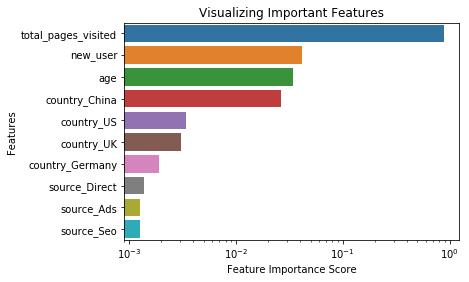

In [25]:
# Visualize feature importance
a=sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
a.set_xscale('log')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

## Conclusion

Based on above model and data visualization, what I can contribute to the team members are:
1. Total pages visited is the most important one for conversion rate. This is reasonable and intuitive because users browsing many pages tends to buy something. They might have a goal so they need to visit mutiple pages and complete payment. What we should do first is to stimulate users without clear shopping goal to click, which means except for what they search, our website should offer more relative or close stuffs to users. Give them the right recommendations and result in more clicks, then they might want to buy, probably take action and finally be converted.

2. We've already known that two thirds of lookers are new users and the rest are repeat users, and probability of conversion of old users is nearly five times than that of new users. Thus, it is very important to retain old customers in order to fortify our business. Consequently, we should further focus on customer retention rate and make a trade-off between targetting old customers and finding new users for marketing and sale teams. Also, we can get some actionable insight by flirting some useful information from this dataset, for example, target new users with total pages visited over 15, analyze the reason why they don't buy what they visited, maybe they were comparing the price with other website or they might care for comments. If they are sensitive to promotions or coupon, then we can send them relative news and coupon. If they concern about comment, we can push them relevant products with top comments at a regular time.  

3. It shows that our website is more easy to convert younger customers compared to people over 55yrs. Thus, for market teams, we should make our advertising exposure more targetd to this generation. Meanwhile, older people might be unwilling to shop online. I think we can evaluate if it is worth or not analyzing some typical user groups and try to identify the reason why they don't like to use our website. If it is actionable, we can update and correct it to convert more older users.

4. For variable country, we can see that China has the most impact among all four countries, which is comprehensible. We have analyzed before that there are many users in China, but mean conversion rate is extremely low. I think we should fully dig into user's shopping experience, because they are visiting our website and the number of users are huge, which means they are interested in what we sell and offer, but they don't take action. It shows that there maybe something wrong with our website in China, for example, delivery, return, exchange, translation and payment way, etc. This can not be solved by a simple A/B testing setup, we might try to analyze the user activity logs, conduct retrospective analysis or conduct user experience research. If we could figure out concrete reason, then conversion rate definitely might have a big improvement.

5. Users mainly originate from United States but their conversion rate is not number one. It is highly likely that our website is from US and people here may have a lot of options. We should try to guarantee the timeliness of website content to remain competitive on the market. Website in Germany has the fewest users but the highest conversion rate. It is a big opportunity for our website in Germany if we can expand our business due to high conversion rate. People in Germany trust our website and they are willing to buy, so we should seize the chance to increase exposure here.

6. Although how people come to our website is not that important compared to other variables, I still want to say that users who attracted by advertisement(Ads) have the highest mean conversion rate, which indicates if our advertisement system can target the potential customers precisely, then conversion performance will improve a lot.


